#  PRÉDICTION ÉMISSIONS GES - BÂTIMENTS SEATTLE
## Notebook 04 : Modélisation Complète avec Pipelines

---

###  Informations

**Dataset** : 1,666 bâtiments (2015-2016)  
**Objectif** : Comparer 2 approches prédictives  
**Date** : Janvier 2026

###  Les 2 Modèles

1. **Modèle 1** : Variables disponibles au permis (sans ENERGY STAR)
2. **Modèle 2** : Avec ENERGY STAR Score

---

# Section 0 : Configuration et Imports

In [1]:
# ============================================================================
# IMPORTS STANDARDS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import importlib.util

# ============================================================================
# CONFIGURATION CHEMINS - VERSION CORRIGÉE
# ============================================================================

# Chemin absolu du projet
PROJECT_ROOT = Path(r"c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3")

# Vérifier que le projet existe
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"❌ Le projet n'existe pas à : {PROJECT_ROOT}")

SRC_PATH = PROJECT_ROOT / 'src'

if not SRC_PATH.exists():
    raise FileNotFoundError(f"❌ Le dossier src n'existe pas à : {SRC_PATH}")

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"✓ PROJECT_ROOT : {PROJECT_ROOT}")
print(f"✓ SRC_PATH : {SRC_PATH}")
print(f"✓ Chemins configurés")

✓ PROJECT_ROOT : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3
✓ SRC_PATH : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\src
✓ Chemins configurés


In [2]:
# ============================================================================
# IMPORTS MODULES PERSONNALISÉS
# ============================================================================

# modeling_utils
spec_modeling = importlib.util.spec_from_file_location("modeling_utils", SRC_PATH / "modeling_utils.py")
modeling_utils = importlib.util.module_from_spec(spec_modeling)
spec_modeling.loader.exec_module(modeling_utils)

# evaluation_utils
spec_eval = importlib.util.spec_from_file_location("evaluation_utils", SRC_PATH / "evaluation_utils.py")
evaluation_utils = importlib.util.module_from_spec(spec_eval)
spec_eval.loader.exec_module(evaluation_utils)

# visualization_utils
spec_viz = importlib.util.spec_from_file_location("visualization_utils", SRC_PATH / "visualization_utils.py")
visualization_utils = importlib.util.module_from_spec(spec_viz)
spec_viz.loader.exec_module(visualization_utils)

# Extraire fonctions
train_multiple_models = modeling_utils.train_multiple_models
save_model = modeling_utils.save_model
get_feature_importance = modeling_utils.get_feature_importance
compare_models = modeling_utils.compare_models

evaluate_model = evaluation_utils.evaluate_model
cv_evaluate_model = evaluation_utils.cv_evaluate_model
compute_residuals_stats = evaluation_utils.compute_residuals_stats
calculate_metrics_summary = evaluation_utils.calculate_metrics_summary
compare_model_performance = evaluation_utils.compare_model_performance

plot_predictions = visualization_utils.plot_predictions
plot_residuals_distribution = visualization_utils.plot_residuals_distribution
plot_feature_importance = visualization_utils.plot_feature_importance
plot_model_comparison = visualization_utils.plot_model_comparison
plot_comparison_two_models = visualization_utils.plot_comparison_two_models

print("✓ Modules personnalisés importés")

✓ Modules personnalisés importés


In [3]:
# ============================================================================
# SCIKIT-LEARN
# ============================================================================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


print("\n" + "="*80)
print("IMPORTS TERMINÉS")
print("="*80)


IMPORTS TERMINÉS


In [4]:
# ============================================================================
# CONFIGURATION
# ============================================================================

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

# Chemins
DATA_DIR = PROJECT_ROOT / 'data'
INTERIM_DIR = DATA_DIR / 'interim_data'
PROCESSED_DIR = DATA_DIR / 'processed_data'
MODELS_DIR = PROJECT_ROOT / 'models'
RESULTS_DIR = PROJECT_ROOT / 'results'
FIGURES_DIR = RESULTS_DIR / 'figures'

for directory in [MODELS_DIR, RESULTS_DIR, FIGURES_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("✓ Configuration terminée")

✓ Configuration terminée


# Section 1 : Chargement des Données

In [5]:
print("="*80)
print("CHARGEMENT DES DONNÉES")
print("="*80)

#  CORRECTION : Chargement depuis PROCESSED_DIR (train_processed.csv)
train_df = pd.read_csv(PROCESSED_DIR / 'train_processed.csv')
test_df = pd.read_csv(PROCESSED_DIR / 'test_processed.csv')

print(f"\n✓ Train : {train_df.shape}")
print(f"✓ Test  : {test_df.shape}")

display(train_df.head())

CHARGEMENT DES DONNÉES

✓ Train : (1332, 23)
✓ Test  : (334, 23)


,BuildingType,PrimaryPropertyType,Address,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,TotalGHGEmissions,TotalGHGEmissions_log,HasElectricity,HasNaturalGas,HasSteam
0,NonResidential,Warehouse,1136 S. Albro Place,GREATER DUWAMISH,47.5465,-122.3170,1963,1.0,1.00,31900.0,0.0,31900.00,"Non-Refrigerated Warehouse, Office",Non-Refrigerated Warehouse,28000.0,Office,4000.0,73.0,13.700,2.6878,1,0,0
1,NonResidential,Hotel,1325 6th Ave,DOWNTOWN,47.6097,-122.3338,1930,1.0,12.45,305548.0,0.0,305548.00,Hotel,Hotel,310000.0,Parking,11745.0,58.0,564.285,6.3373,1,1,1
2,Nonresidential COS,Small- and Mid-Sized Office,1300 N 97th ST,NORTHWEST,47.7004,-122.3414,1957,1.0,2.00,91130.0,0.0,91130.00,"Data Center, Distribution Center, Office, Othe...",Office,57968.0,Distribution Center,32881.0,73.0,175.770,5.1748,1,1,0
3,NonResidential,Warehouse,4100 4th Avenue South,GREATER DUWAMISH,47.5656,-122.3289,1956,1.0,1.00,98480.0,0.0,98480.00,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,98480.0,Parking,11745.0,65.0,39.500,3.7013,1,1,0
4,NonResidential,Other,1004 Boren Ave,EAST,47.6097,-122.3250,1912,1.0,3.00,21038.2,0.0,20804.25,Social/Meeting Hall,Social/Meeting Hall,20411.0,Parking,11745.0,73.0,71.230,4.2799,1,1,0


# Section 2 : Analyse de la Target

In [6]:
TARGET = 'TotalGHGEmissions_log'

if TARGET not in train_df.columns:
    print(f"⚠ Création de {TARGET}...")
    train_df[TARGET] = np.log1p(train_df['TotalGHGEmissions'])
    test_df[TARGET] = np.log1p(test_df['TotalGHGEmissions'])

y_train = train_df[TARGET]
y_test = test_df[TARGET]

print("="*80)
print("ANALYSE TARGET")
print("="*80)
print("\nTrain :")
print(y_train.describe())
print("\nTest :")
print(y_test.describe())

ANALYSE TARGET

Train :
count    1332.0000
mean        3.9679
std         1.3305
min         1.5196
25%         3.0392
50%         3.9330
75%         4.9220
max         6.3373
Name: TotalGHGEmissions_log, dtype: float64

Test :
count    334.0000
mean       3.9886
std        1.2895
min        1.5196
25%        3.0602
50%        3.8889
75%        5.0138
max        6.3373
Name: TotalGHGEmissions_log, dtype: float64


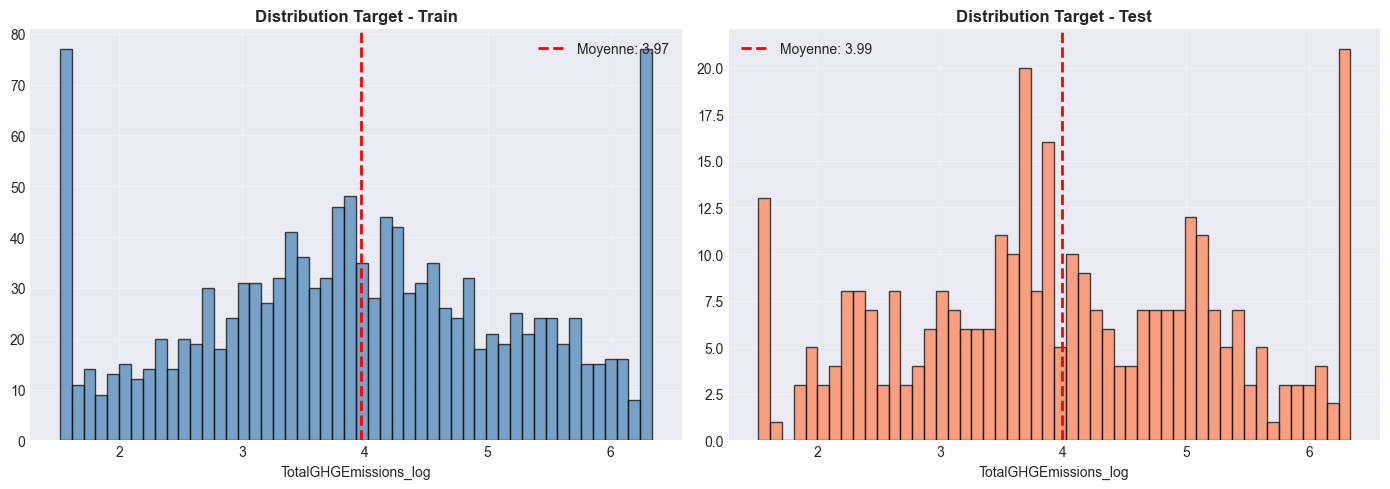

In [7]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {y_train.mean():.2f}')
axes[0].set_title('Distribution Target - Train', fontweight='bold')
axes[0].set_xlabel(TARGET)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_test, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {y_test.mean():.2f}')
axes[1].set_title('Distribution Target - Test', fontweight='bold')
axes[1].set_xlabel(TARGET)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Section 3 : Définition des Variables

In [ ]:
# ============================================================================
# MODÈLE 1 : SANS ENERGY STAR
# ============================================================================

# Les données dans train_processed.csv sont déjà nettoyées (23 colonnes)

# Toutes colonnes SAUF target et ENERGYSTARScore
variables_m1 = [col for col in train_df.columns 
                if col != TARGET and col != 'ENERGYSTARScore' and col != 'TotalGHGEmissions']

# ============================================================================
# MODÈLE 2 : AVEC ENERGY STAR
# ============================================================================

# Toutes colonnes SAUF target
variables_m2 = [col for col in train_df.columns if col != TARGET and col != 'TotalGHGEmissions']

print(f"\n MODÈLE 1 : {len(variables_m1)} variables (sans ENERGY STAR)")
print(f" MODÈLE 2 : {len(variables_m2)} variables (avec ENERGY STAR)")

print(f"\n🔍 Variables MODÈLE 1 :")
print(variables_m1)
print(f"\n🔍 Variables MODÈLE 2 :")
print(variables_m2)


 MODÈLE 1 : 21 variables (sans ENERGY STAR)
 MODÈLE 2 : 22 variables (avec ENERGY STAR)

🔍 Variables MODÈLE 1 :
['BuildingType', 'PrimaryPropertyType', 'Address', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'TotalGHGEmissions', 'HasElectricity', 'HasNaturalGas', 'HasSteam']

🔍 Variables MODÈLE 2 :
['BuildingType', 'PrimaryPropertyType', 'Address', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'TotalGHGEmissions', 'HasElectricity', 'HasNatural

# Section 4 : Préparation des Datasets

In [9]:
# ============================================================================
# MODÈLE 1
# ============================================================================

print("="*80)
print("PRÉPARATION MODÈLE 1")
print("="*80)

X_train_m1 = train_df[variables_m1].copy()
X_test_m1 = test_df[variables_m1].copy()

# Gestion variables catégorielles
categorical_cols = X_train_m1.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    print(f"\n⚠ {len(categorical_cols)} variables catégorielles → OneHotEncoding")
    X_train_m1 = pd.get_dummies(X_train_m1, columns=categorical_cols, drop_first=True)
    X_test_m1 = pd.get_dummies(X_test_m1, columns=categorical_cols, drop_first=True)
    X_train_m1, X_test_m1 = X_train_m1.align(X_test_m1, join='left', axis=1, fill_value=0)
    print(f"   ✓ {X_train_m1.shape[1]} features après encodage")

print(f"\n✓ X_train_m1 : {X_train_m1.shape}")
print(f"✓ X_test_m1  : {X_test_m1.shape}")

PRÉPARATION MODÈLE 1

⚠ 7 variables catégorielles → OneHotEncoding
   ✓ 1780 features après encodage

✓ X_train_m1 : (1332, 1780)
✓ X_test_m1  : (334, 1780)


In [11]:
X_train_m1.head(10)

Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
0   47.5465  -122.3170       1963                1.0            1.00   
1   47.6097  -122.3338       1930                1.0           12.45   
2   47.7004  -122.3414       1957                1.0            2.00   
3   47.5656  -122.3289       1956                1.0            1.00   
4   47.6097  -122.3250       1912                1.0            3.00   
5   47.6990  -122.3416       1982                1.0            3.00   
6   47.5603  -122.2884       1967                1.0            2.00   
7   47.5606  -122.3252       2001                1.0            1.00   
8   47.6041  -122.3396       1906                1.0            1.00   
9   47.6335  -122.3263       1962                1.0            3.00   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0           31900.0                 0.0                31900.00   
1          305548.0                 0.0               305548.00   
2           91130.0                 0.0                91130.00   
3           98480.0                 0.0                98480.00   
4           21038.2                 0.0                20804.25   
5           25111.0                 0.0                25111.00   
6           23250.0                 0.0                23250.00   
7          123061.0                 0.0               123061.00   
8           62900.0                 0.0                62900.00   
9          158600.0             38400.0               120200.00   

   LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
0                    28000.0                           4000.0   
1                   310000.0                          11745.0   
2                    57968.0                          32881.0   
3                    98480.0                          11745.0   
4                    20411.0                          11745.0   
5                    14317.0                           7850.0   
6                    22014.0                          11745.0   
7                   123061.0                          11745.0   
8                    32494.0                          29793.0   
9                   125779.0                          32821.0   

   TotalGHGEmissions  HasElectricity  HasNaturalGas  HasSteam  \
0             13.700               1              0         0   
1            564.285               1              1         1   
2            175.770               1              1         0   
3             39.500               1              1         0   
4             71.230               1              1         0   
5             24.970               1              1         0   
6              6.300               1              0         0   
7             13.860               1              0         0   
8            377.270               1              1         0   
9            236.900               1              1         0   

   BuildingType_NonResidential  BuildingType_Nonresidential COS  \
0                         True                            False   
1                         True                            False   
2                        False                             True   
3                         True                            False   
4                         True                            False   
5                         True                            False   
6                         True                            False   
7                         True                            False   
8                         True                            False   
9                         True                            False   

   BuildingType_SPS-District K-12  PrimaryPropertyType_Hospital  \
0                           False                         False   
1                           False                         False   
2                           False                         False   
3                           False 

In [12]:
# ============================================================================
# MODÈLE 2
# ============================================================================

print("="*80)
print("PRÉPARATION MODÈLE 2")
print("="*80)

X_train_m2 = train_df[variables_m2].copy()
X_test_m2 = test_df[variables_m2].copy()

# Imputation ENERGY STAR
if 'ENERGYSTARScore' in X_train_m2.columns:
    missing = X_train_m2['ENERGYSTARScore'].isnull().sum()
    if missing > 0:
        print(f"\n⚠ {missing} valeurs manquantes ENERGYSTARScore")
        median_val = X_train_m2['ENERGYSTARScore'].median()
        X_train_m2['ENERGYSTARScore'].fillna(median_val, inplace=True)
        X_test_m2['ENERGYSTARScore'].fillna(median_val, inplace=True)
        print(f"   ✓ Imputation médiane = {median_val:.2f}")

# Gestion variables catégorielles
categorical_cols_m2 = X_train_m2.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols_m2) > 0:
    print(f"\n⚠ {len(categorical_cols_m2)} variables catégorielles → OneHotEncoding")
    X_train_m2 = pd.get_dummies(X_train_m2, columns=categorical_cols_m2, drop_first=True)
    X_test_m2 = pd.get_dummies(X_test_m2, columns=categorical_cols_m2, drop_first=True)
    X_train_m2, X_test_m2 = X_train_m2.align(X_test_m2, join='left', axis=1, fill_value=0)
    print(f"   ✓ {X_train_m2.shape[1]} features après encodage")

print(f"\n✓ X_train_m2 : {X_train_m2.shape}")
print(f"✓ X_test_m2  : {X_test_m2.shape}")

PRÉPARATION MODÈLE 2

⚠ 7 variables catégorielles → OneHotEncoding
   ✓ 1781 features après encodage

✓ X_train_m2 : (1332, 1781)
✓ X_test_m2  : (334, 1781)


# Section 5 : MODÈLE 1 - Baseline avec Pipelines

In [13]:
# ============================================================================
# DÉFINITION PIPELINES - MODÈLE 1
# ============================================================================

print("="*80)
print("MODÈLE 1 - BASELINE AVEC PIPELINES")
print("="*80)

pipelines_m1 = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=RANDOM_STATE))
    ]),
    
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE
        ))
    ]),
    
    'SVR': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf'))
    ])
}


print(f"\n✓ {len(pipelines_m1)} pipelines créés")

MODÈLE 1 - BASELINE AVEC PIPELINES

✓ 5 pipelines créés


In [14]:
# ============================================================================
# ENTRAÎNEMENT - MODÈLE 1
# ============================================================================

results_df_m1, trained_pipelines_m1 = train_multiple_models(
    pipelines_m1,
    X_train_m1,
    y_train,
    X_test_m1,
    y_test,
    cv=5,
    verbose=True
)

print("\n RÉSULTATS BASELINE - MODÈLE 1")
display(results_df_m1[['model', 'test_r2', 'test_rmse_log', 'test_mae_log', 
                       'test_rmse_original', 'test_mape', 'overfitting_r2']].round(4))

ENTRAÎNEMENT MULTIPLE MODÈLES

Nombre de modèles : 5
Cross-validation : 5-fold

Traitement : Ridge
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 8.56s
   R² Test : 0.6359
   RMSE Test : 0.7769

Traitement : Lasso
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 1.53s
   R² Test : 0.1390
   RMSE Test : 1.1948

Traitement : Random Forest
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 16.53s
   R² Test : 1.0000
   RMSE Test : 0.0043

Traitement : Gradient Boosting
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 11.47s
   R² Test : 0.9999
   RMSE Test : 0.0118

Traitement : SVR
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 21.17s
   R² Test : 0.1914
   RMSE Test : 1.1578

✓ ENTRAÎNEMENT TERMINÉ

 RÉSULTATS BASELINE - MODÈLE 1


,model,test_r2,test_rmse_log,test_mae_log,test_rmse_original,test_mape,overfitting_r2
2,Random Forest,1.0000,0.0043,0.0029,0.8451,0.3047,0.0000
3,Gradient Boosting,0.9999,0.0118,0.0087,1.8053,0.9077,0.0000
0,Ridge,0.6359,0.7769,0.6115,94.9668,94.9108,0.3640
4,SVR,0.1914,1.1578,0.9643,121.6794,70.1355,0.6966
1,Lasso,0.1390,1.1948,0.9879,155.1648,168.6580,-0.0033


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\baseline_m1.png


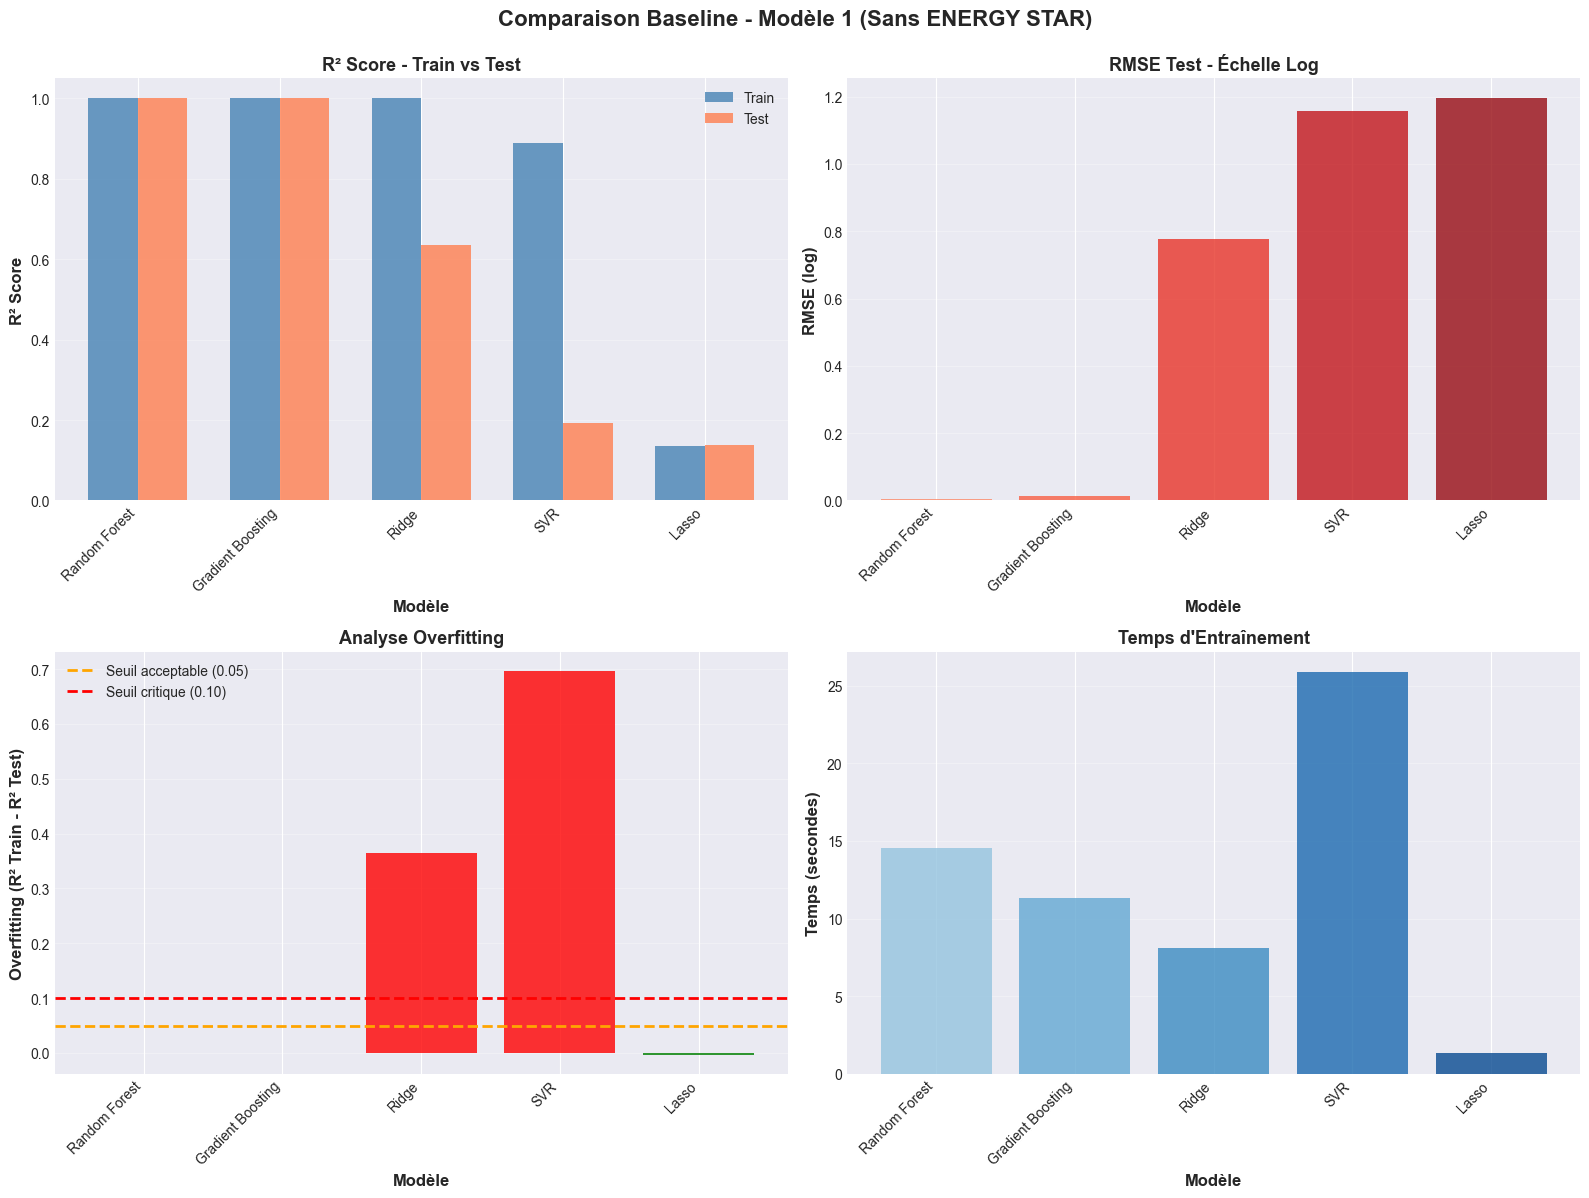

In [13]:
# Visualisation
plot_model_comparison(
    results_df_m1,
    title="Comparaison Baseline - Modèle 1 (Sans ENERGY STAR)",
    save_path=FIGURES_DIR / 'baseline_m1.png'
)

# Section 6 : MODÈLE 1 - Analyse

In [14]:
# ============================================================================
# MEILLEUR MODÈLE - MODÈLE 1
# ============================================================================

best_model_name_m1 = results_df_m1.iloc[0]['model']
best_pipeline_m1 = trained_pipelines_m1[best_model_name_m1]
best_metrics_m1 = results_df_m1.iloc[0].to_dict()

print("="*80)
print(f"MEILLEUR MODÈLE 1 : {best_model_name_m1}")
print("="*80)

summary_m1 = calculate_metrics_summary(best_metrics_m1)
display(summary_m1)

MEILLEUR MODÈLE 1 : Random Forest


,Métrique,Valeur,Interprétation
0,R² Score (Test),1.0000,Excellent
1,RMSE (échelle originale),0.85 tonnes CO₂,Erreur moyenne quadratique
2,MAPE (%),0.30%,Excellent
3,Overfitting (R²),0.0000,Pas d'overfitting


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\feature_importance_m1.png


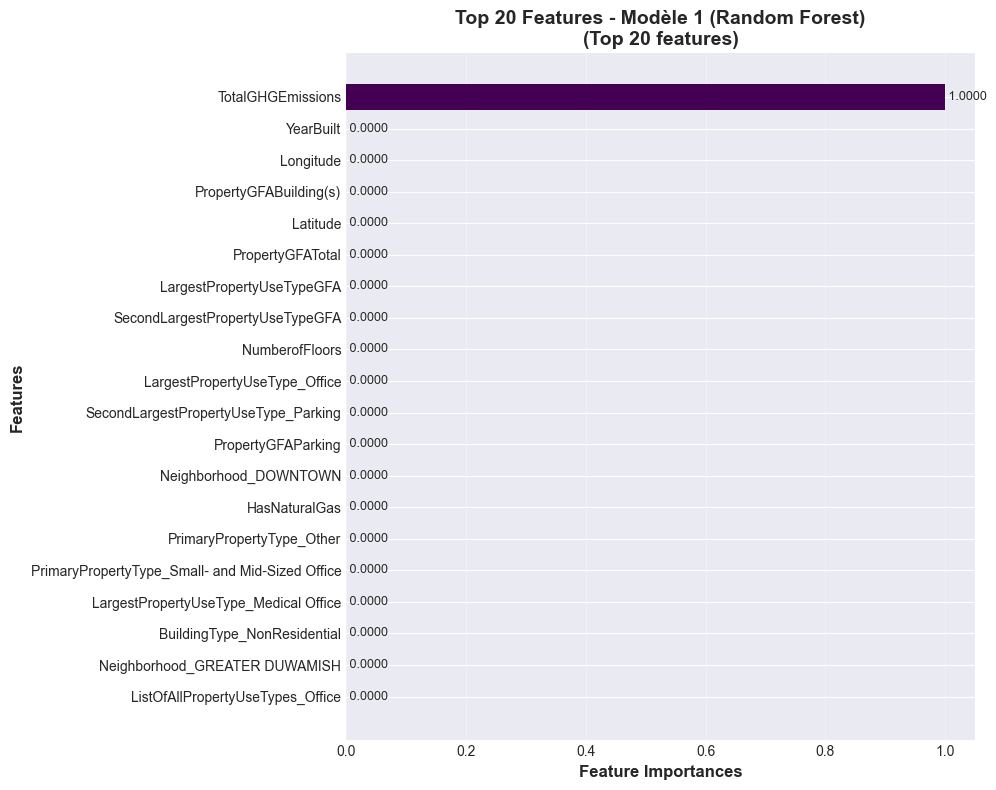


Top 10 Features :


,feature,importance
10,TotalGHGEmissions,9.9998e-01
2,YearBuilt,2.7254e-06
1,Longitude,2.4728e-06
7,PropertyGFABuilding(s),2.3336e-06
0,Latitude,2.2034e-06
5,PropertyGFATotal,1.9753e-06
8,LargestPropertyUseTypeGFA,1.7619e-06
9,SecondLargestPropertyUseTypeGFA,1.1446e-06
4,NumberofFloors,9.5273e-07
1706,LargestPropertyUseType_Office,5.7739e-07


In [15]:
# Feature Importance
if hasattr(best_pipeline_m1.named_steps['model'], 'feature_importances_') or \
   hasattr(best_pipeline_m1.named_steps['model'], 'coef_'):
    
    importance_df_m1 = plot_feature_importance(
        best_pipeline_m1.named_steps['model'],
        X_train_m1.columns,
        top_n=20,
        title=f"Top 20 Features - Modèle 1 ({best_model_name_m1})",
        save_path=FIGURES_DIR / 'feature_importance_m1.png'
    )
    
    print("\nTop 10 Features :")
    display(importance_df_m1.head(10))
else:
    print("⚠ Feature importance non disponible pour ce modèle")

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\predictions_m1.png


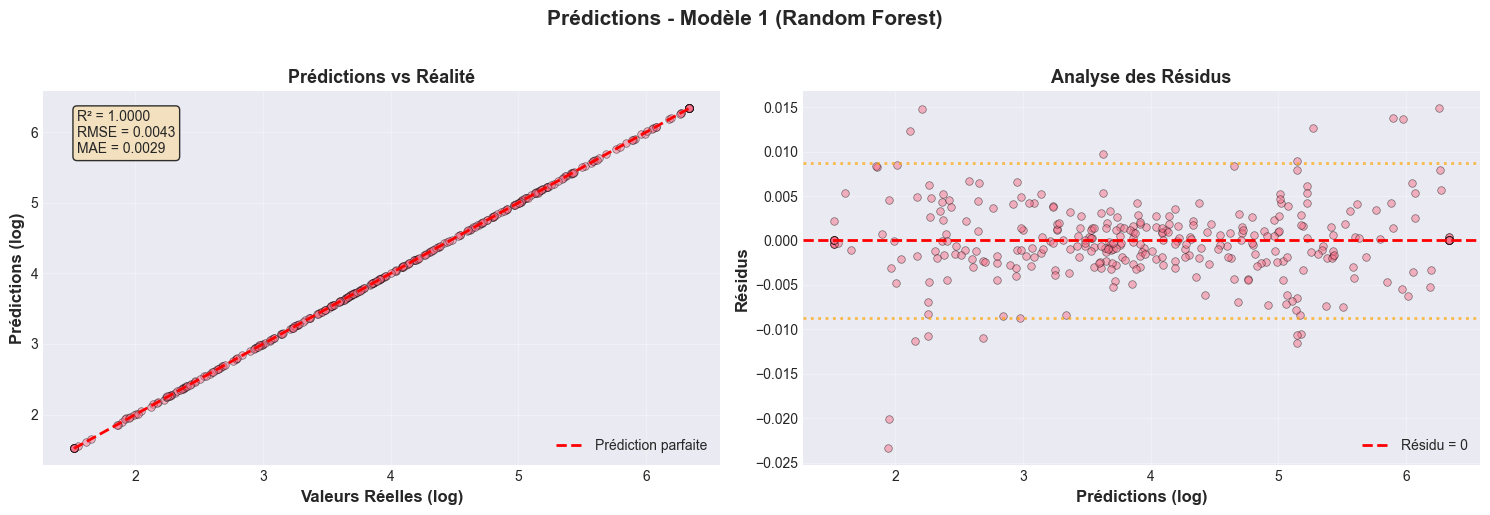

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\residuals_m1.png


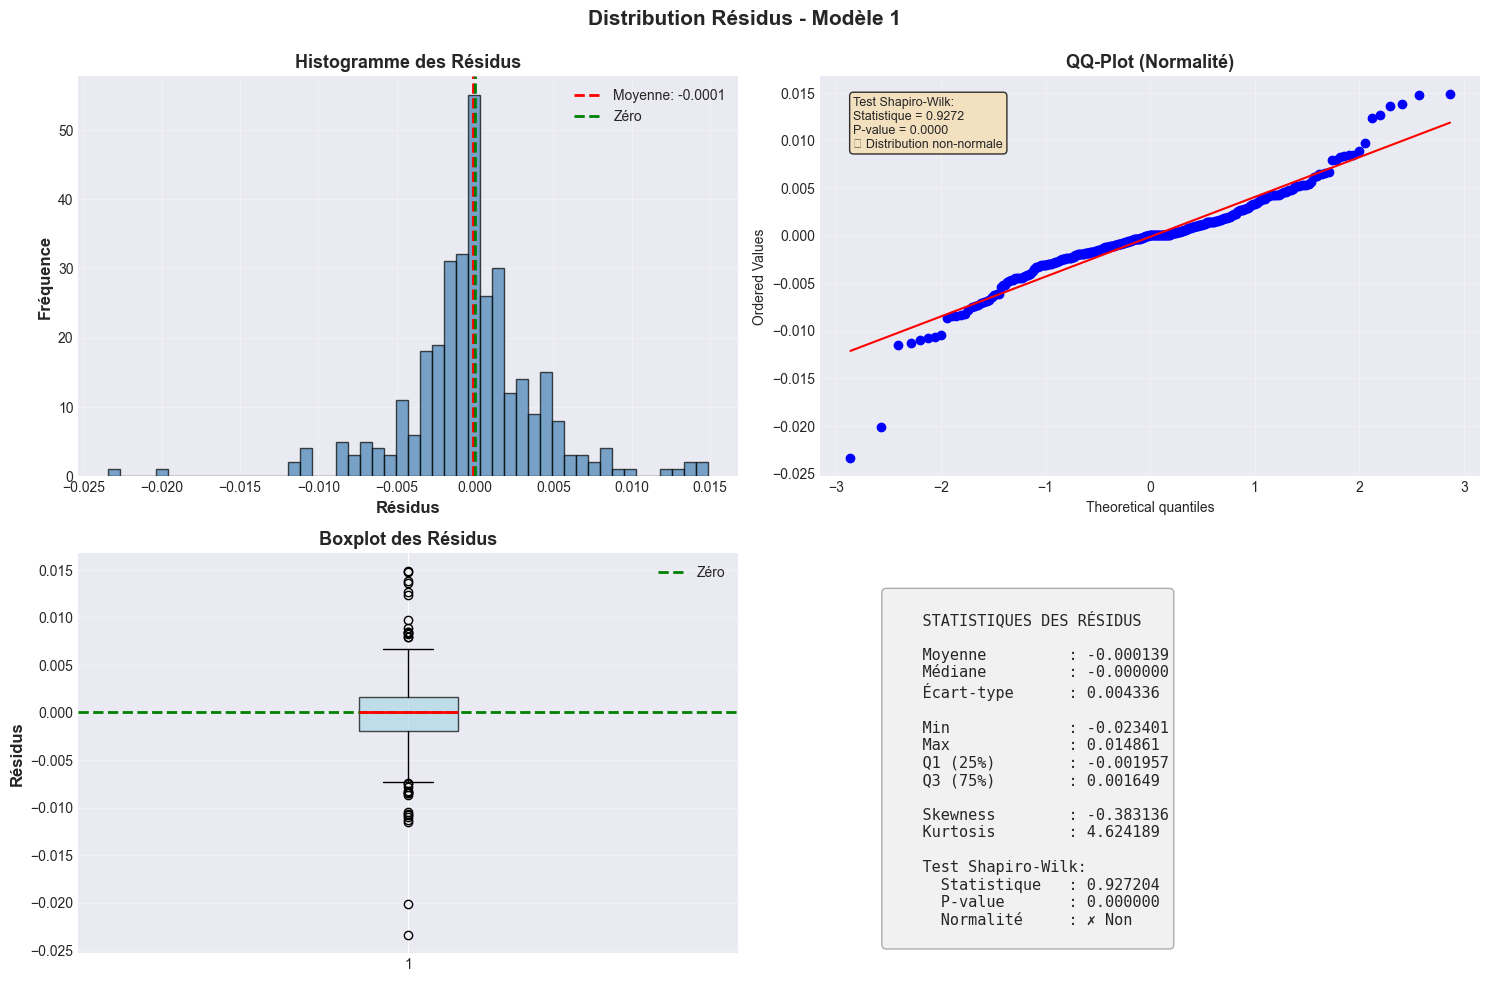

In [16]:
# Analyse Résidus
y_pred_m1 = best_pipeline_m1.predict(X_test_m1)

plot_predictions(
    y_test, y_pred_m1,
    title=f"Prédictions - Modèle 1 ({best_model_name_m1})",
    save_path=FIGURES_DIR / 'predictions_m1.png'
)

residuals_m1 = y_test - y_pred_m1
plot_residuals_distribution(
    residuals_m1,
    title="Distribution Résidus - Modèle 1",
    save_path=FIGURES_DIR / 'residuals_m1.png'
)

# Section 7 : MODÈLE 2 - Baseline avec Pipelines

In [15]:
# ============================================================================
# DÉFINITION PIPELINES - MODÈLE 2
# ============================================================================

print("="*80)
print("MODÈLE 2 - BASELINE AVEC PIPELINES")
print("="*80)

pipelines_m2 = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=RANDOM_STATE))
    ]),
    
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE
        ))
    ]),
    
    'SVR': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf'))
    ])
}



print(f"\n✓ {len(pipelines_m2)} pipelines créés")

MODÈLE 2 - BASELINE AVEC PIPELINES

✓ 5 pipelines créés


In [16]:
# ============================================================================
# ENTRAÎNEMENT - MODÈLE 2
# ============================================================================

results_df_m2, trained_pipelines_m2 = train_multiple_models(
    pipelines_m2,
    X_train_m2,
    y_train,
    X_test_m2,
    y_test,
    cv=5,
    verbose=True
)

print("\n RÉSULTATS BASELINE - MODÈLE 2")
display(results_df_m2[['model', 'test_r2', 'test_rmse_log', 'test_mae_log', 
                       'test_rmse_original', 'test_mape', 'overfitting_r2']].round(4))

ENTRAÎNEMENT MULTIPLE MODÈLES

Nombre de modèles : 5
Cross-validation : 5-fold

Traitement : Ridge
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 10.17s
   R² Test : 0.6344
   RMSE Test : 0.7786

Traitement : Lasso
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 1.71s
   R² Test : 0.1390
   RMSE Test : 1.1948

Traitement : Random Forest
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 18.09s
   R² Test : 1.0000
   RMSE Test : 0.0044

Traitement : Gradient Boosting
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 13.41s
   R² Test : 0.9999
   RMSE Test : 0.0118

Traitement : SVR
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 27.17s
   R² Test : 0.1946
   RMSE Test : 1.1555

✓ ENTRAÎNEMENT TERMINÉ

 RÉSULTATS BASELINE - MODÈLE 2


,model,test_r2,test_rmse_log,test_mae_log,test_rmse_original,test_mape,overfitting_r2
2,Random Forest,1.0000,0.0044,0.0029,0.8242,0.3072,0.0000
3,Gradient Boosting,0.9999,0.0118,0.0087,1.8046,0.9078,0.0000
0,Ridge,0.6344,0.7786,0.6144,94.2632,94.8289,0.3656
4,SVR,0.1946,1.1555,0.9657,122.9092,69.8791,0.6958
1,Lasso,0.1390,1.1948,0.9879,155.1648,168.6580,-0.0033


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\baseline_m2.png


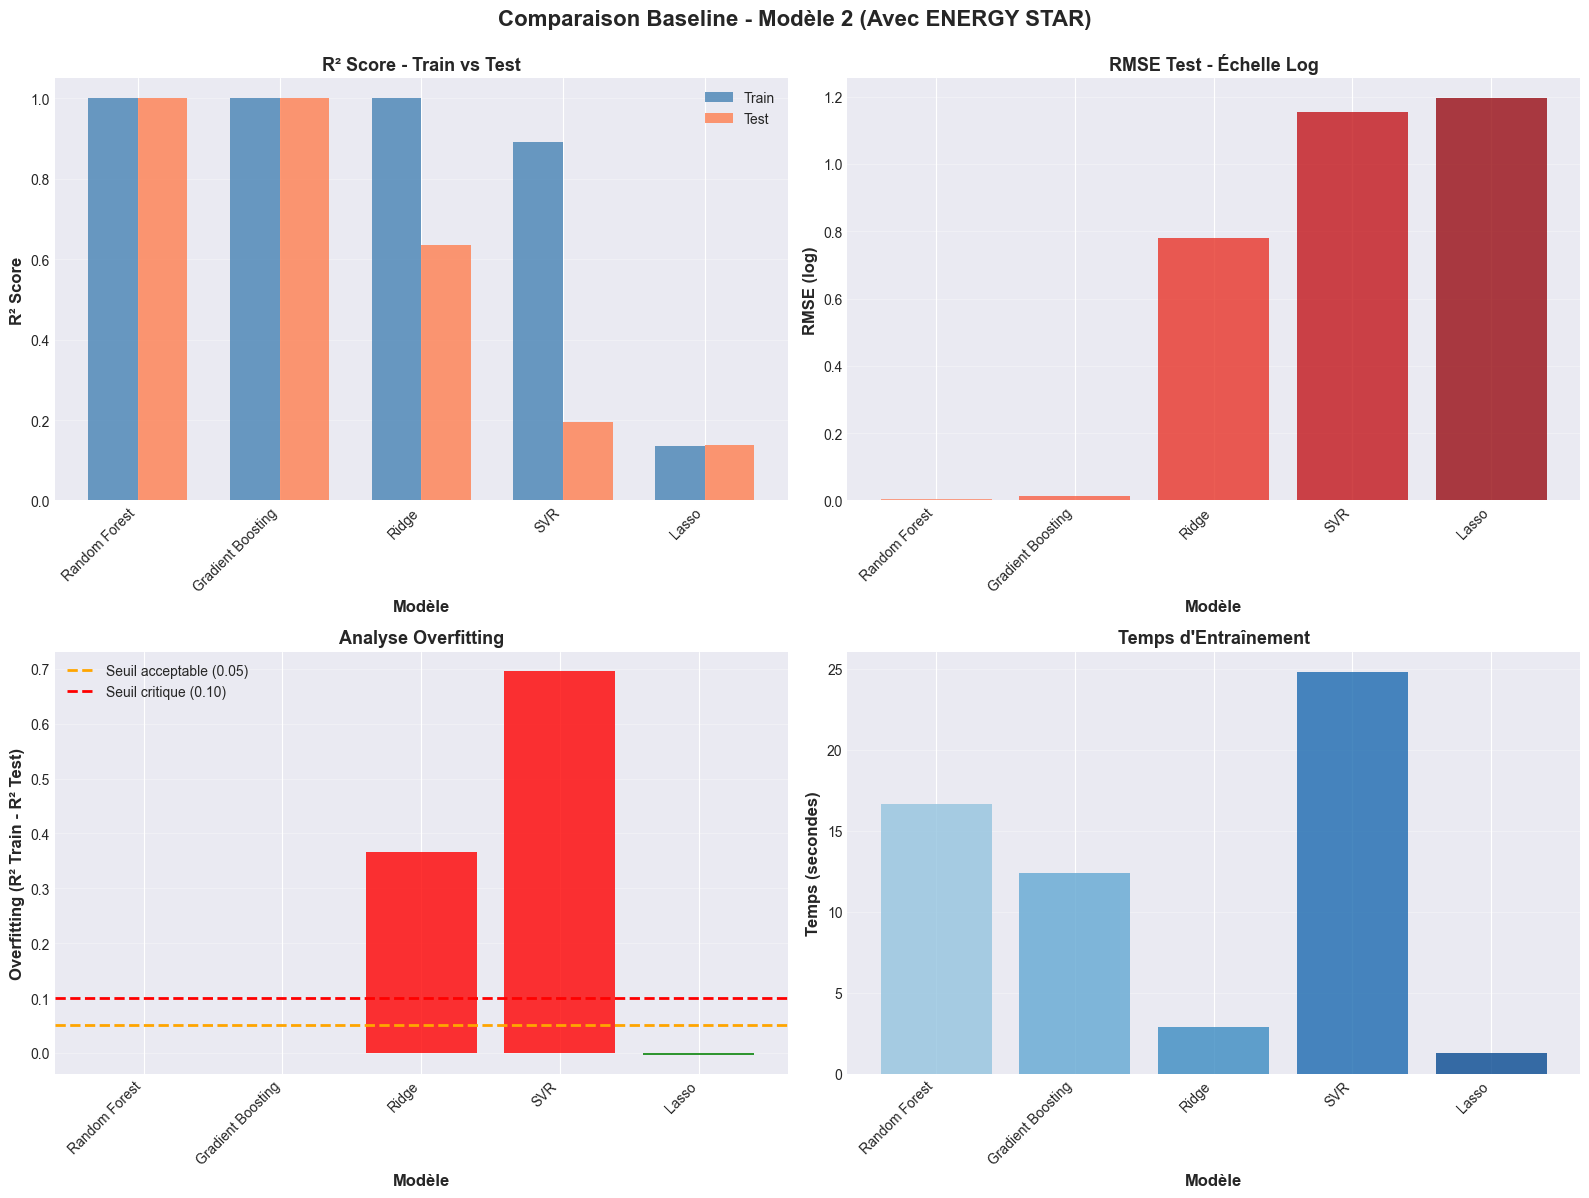

In [19]:
# Visualisation
plot_model_comparison(
    results_df_m2,
    title="Comparaison Baseline - Modèle 2 (Avec ENERGY STAR)",
    save_path=FIGURES_DIR / 'baseline_m2.png'
)

# Section 8 : MODÈLE 2 - Analyse

In [20]:
# ============================================================================
# MEILLEUR MODÈLE - MODÈLE 2
# ============================================================================

best_model_name_m2 = results_df_m2.iloc[0]['model']
best_pipeline_m2 = trained_pipelines_m2[best_model_name_m2]
best_metrics_m2 = results_df_m2.iloc[0].to_dict()

print("="*80)
print(f"MEILLEUR MODÈLE 2 : {best_model_name_m2}")
print("="*80)

summary_m2 = calculate_metrics_summary(best_metrics_m2)
display(summary_m2)

MEILLEUR MODÈLE 2 : Random Forest


,Métrique,Valeur,Interprétation
0,R² Score (Test),1.0000,Excellent
1,RMSE (échelle originale),0.82 tonnes CO₂,Erreur moyenne quadratique
2,MAPE (%),0.31%,Excellent
3,Overfitting (R²),0.0000,Pas d'overfitting


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\feature_importance_m2.png


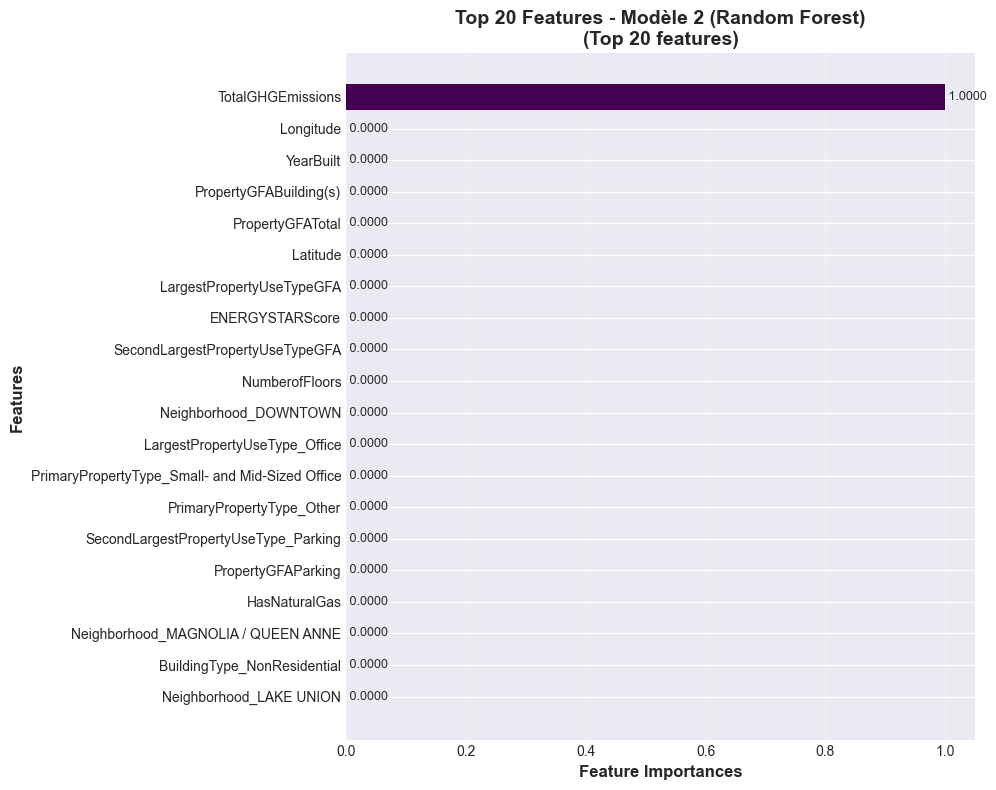


Top 10 Features :


,feature,importance
11,TotalGHGEmissions,9.9997e-01
1,Longitude,2.5426e-06
2,YearBuilt,2.3467e-06
7,PropertyGFABuilding(s),2.1632e-06
5,PropertyGFATotal,2.1006e-06
0,Latitude,2.0213e-06
8,LargestPropertyUseTypeGFA,1.8195e-06
10,ENERGYSTARScore,1.5522e-06
9,SecondLargestPropertyUseTypeGFA,1.0376e-06
4,NumberofFloors,1.0308e-06



 ENERGYSTARScore : Rang 11 | Importance 0.0000


In [21]:
# Feature Importance + Position ENERGY STAR
if hasattr(best_pipeline_m2.named_steps['model'], 'feature_importances_') or \
   hasattr(best_pipeline_m2.named_steps['model'], 'coef_'):
    
    importance_df_m2 = plot_feature_importance(
        best_pipeline_m2.named_steps['model'],
        X_train_m2.columns,
        top_n=20,
        title=f"Top 20 Features - Modèle 2 ({best_model_name_m2})",
        save_path=FIGURES_DIR / 'feature_importance_m2.png'
    )
    
    print("\nTop 10 Features :")
    display(importance_df_m2.head(10))
    
    # Position ENERGY STAR
    if 'ENERGYSTARScore' in importance_df_m2['feature'].values:
        energy_rank = importance_df_m2[importance_df_m2['feature'] == 'ENERGYSTARScore'].index[0] + 1
        energy_importance = importance_df_m2[importance_df_m2['feature'] == 'ENERGYSTARScore']['importance'].values[0]
        print(f"\n ENERGYSTARScore : Rang {energy_rank} | Importance {energy_importance:.4f}")
else:
    print("⚠ Feature importance non disponible")

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\predictions_m2.png


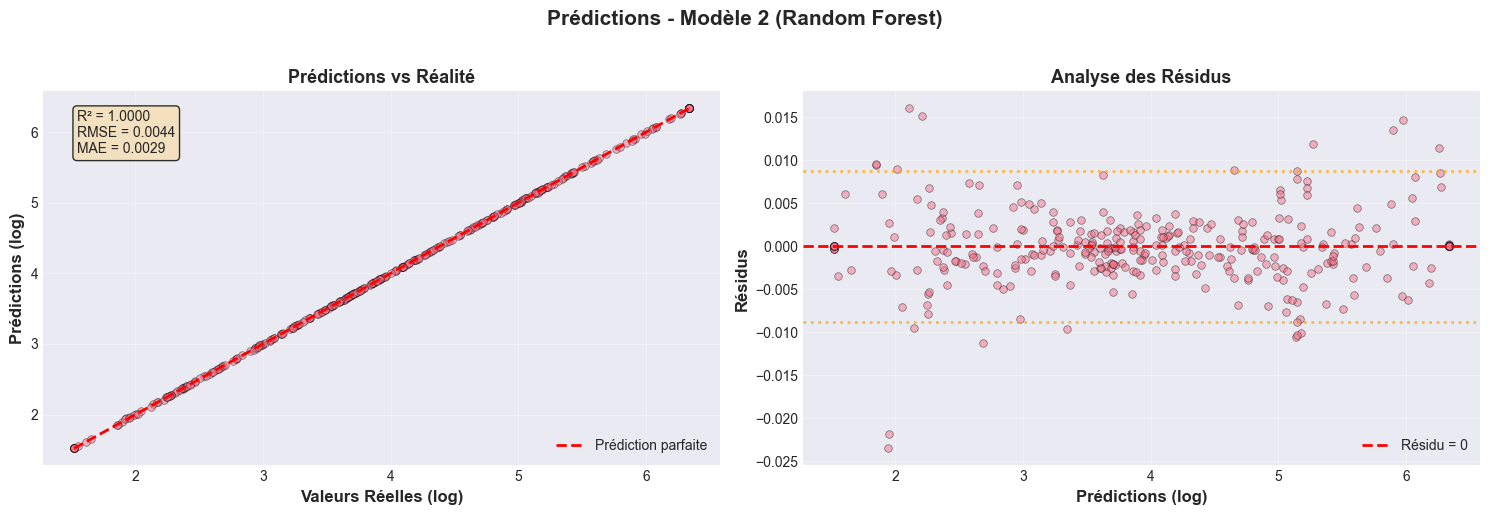

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\residuals_m2.png


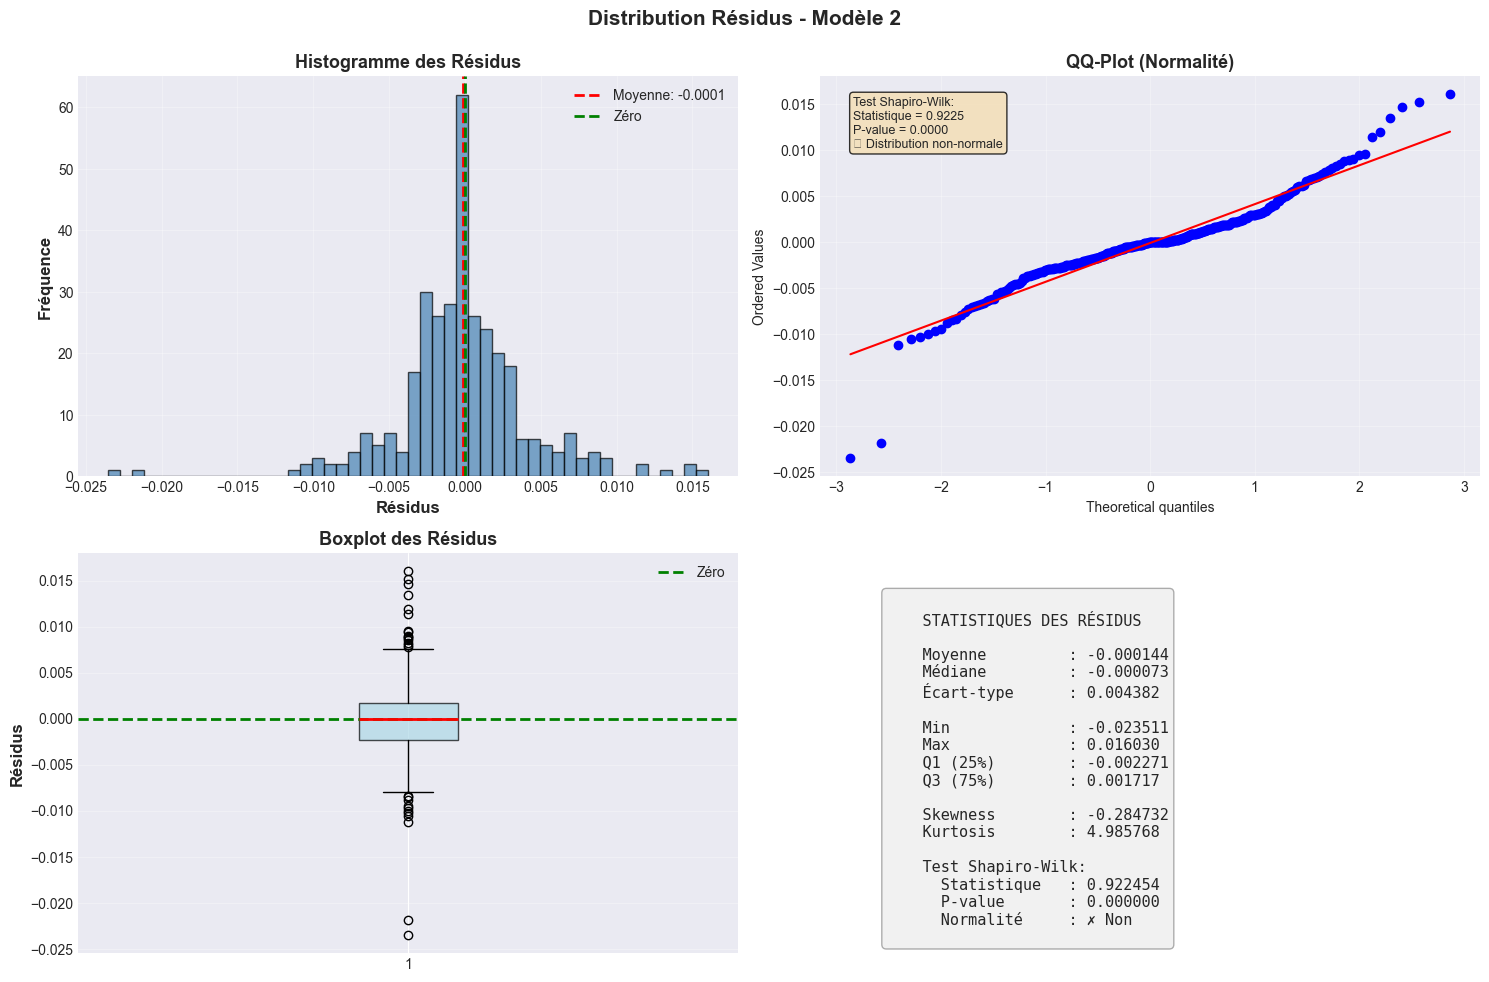

In [22]:
# Analyse Résidus
y_pred_m2 = best_pipeline_m2.predict(X_test_m2)

plot_predictions(
    y_test, y_pred_m2,
    title=f"Prédictions - Modèle 2 ({best_model_name_m2})",
    save_path=FIGURES_DIR / 'predictions_m2.png'
)

residuals_m2 = y_test - y_pred_m2
plot_residuals_distribution(
    residuals_m2,
    title="Distribution Résidus - Modèle 2",
    save_path=FIGURES_DIR / 'residuals_m2.png'
)

# Section 8.5 : Comparaison Rigoureuse (Même Algorithme)

---

##  MÉTHODOLOGIE CORRECTE

Pour comparer scientifiquement l'apport d'**ENERGY STAR**, on doit comparer **le même algorithme** dans les 2 scénarios :

1. **Identifier le meilleur algorithme global** (tous modèles M1 et M2 confondus)
2. **Comparer cet algorithme** avec/sans ENERGY STAR
3. **Isoler l'effet pur** de la variable ENERGY STAR

 **Approche incorrecte** : Comparer le meilleur de M1 (ex: Gradient Boosting) avec le meilleur de M2 (ex: Random Forest)

 **Approche correcte** : Identifier d'abord le meilleur algorithme global, puis comparer cet algorithme dans les 2 scénarios

---

IDENTIFICATION MEILLEUR ALGORITHME GLOBAL

🏆 TOP 5 MEILLEURS MODÈLES (TOUS SCÉNARIOS CONFONDUS)


,model,scenario,test_r2,test_rmse_log,test_mae_log
2,Random Forest,Modèle 1 (Sans ENERGY STAR),1.0000,0.0043,0.0029
2,Random Forest,Modèle 2 (Avec ENERGY STAR),1.0000,0.0044,0.0029
3,Gradient Boosting,Modèle 2 (Avec ENERGY STAR),0.9999,0.0118,0.0087
3,Gradient Boosting,Modèle 1 (Sans ENERGY STAR),0.9999,0.0118,0.0087
0,Ridge,Modèle 1 (Sans ENERGY STAR),0.6359,0.7769,0.6115



✨ Meilleur algorithme global : Random Forest

COMPARAISON RANDOM FOREST : AVEC vs SANS ENERGY STAR

 TABLEAU COMPARATIF


,Métrique,Modèle 1 (Sans ENERGY STAR),Modèle 2 (Avec ENERGY STAR),Gain Absolu,Gain %
0,R²,1.0000,1.0000,-0.0,-0.0000
1,RMSE,0.0043,0.0044,0.0,1.0689
2,MAE,0.0029,0.0029,0.0,0.6279



 INTERPRÉTATION DES RÉSULTATS

 Apport d' ENERGY STAR pour Random Forest :
   • Gain R²   : -0.0000 (-0.00%)
   • Gain RMSE : -0.0000 (-1.07%)
   • Gain MAE  : -0.0000 (-0.63%)

 CONCLUSION : ENERGY STAR n'apporte pas d'amélioration notable

 Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\comparison_rigorous.png


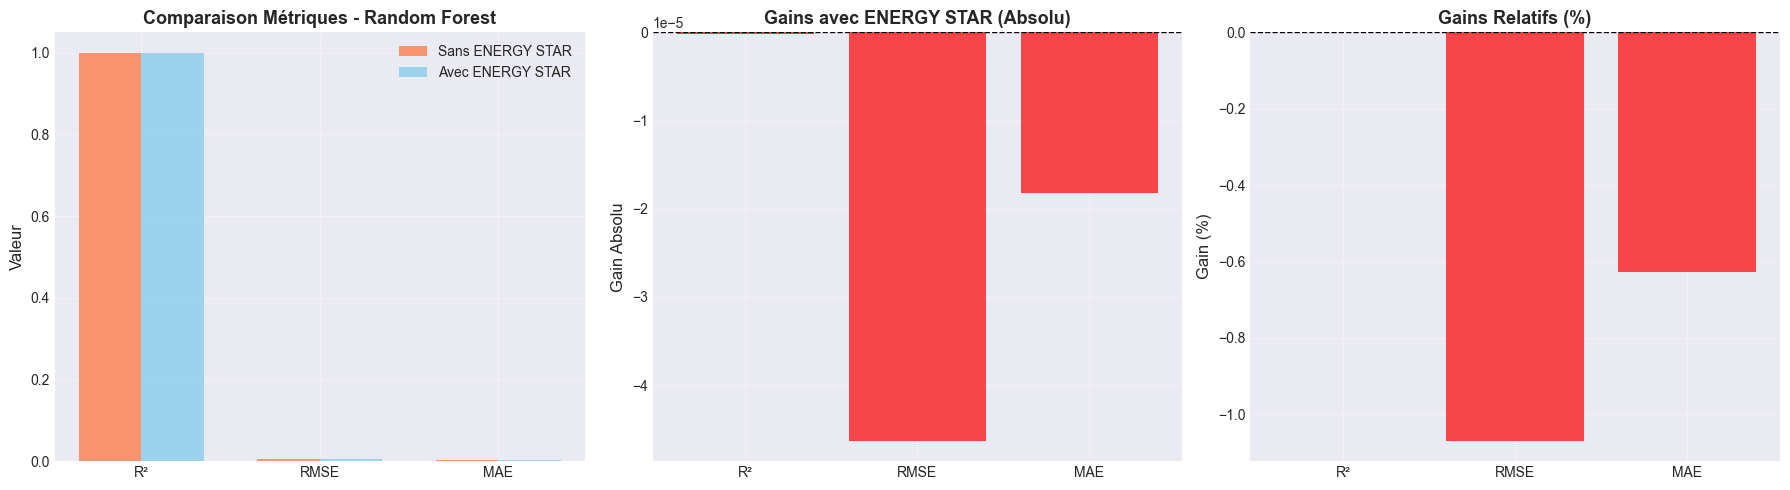

 Comparaison sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\comparison_rigorous.csv

 COMPARAISON RIGOUREUSE TERMINÉE


In [24]:
print("="*80)
print("IDENTIFICATION MEILLEUR ALGORITHME GLOBAL")
print("="*80)

# ============================================================================
# COMBINER TOUS LES RÉSULTATS
# ============================================================================

all_results = pd.concat([
    results_df_m1.assign(scenario='Modèle 1 (Sans ENERGY STAR)'),
    results_df_m2.assign(scenario='Modèle 2 (Avec ENERGY STAR)')
])

# Trier par R² test (meilleur = plus élevé)
all_results_sorted = all_results.sort_values('test_r2', ascending=False)

print("\n🏆 TOP 5 MEILLEURS MODÈLES (TOUS SCÉNARIOS CONFONDUS)")
print("="*80)
display(all_results_sorted[['model', 'scenario', 'test_r2', 'test_rmse_log', 'test_mae_log']].head())

# Identifier meilleur algorithme
best_algorithm = all_results_sorted.iloc[0]['model']
print(f"\n✨ Meilleur algorithme global : {best_algorithm}")

# ============================================================================
# COMPARAISON RIGOUREUSE : MÊME ALGORITHME AVEC/SANS ENERGY STAR
# ============================================================================

print("\n" + "="*80)
print(f"COMPARAISON {best_algorithm.upper()} : AVEC vs SANS ENERGY STAR")
print("="*80)

# Extraire les résultats pour cet algorithme dans les 2 scénarios
best_m1_algo = results_df_m1[results_df_m1['model'] == best_algorithm].iloc[0]
best_m2_algo = results_df_m2[results_df_m2['model'] == best_algorithm].iloc[0]

# Créer DataFrame de comparaison
comparison_df = pd.DataFrame({
    'Métrique': ['R²', 'RMSE', 'MAE'],
    'Modèle 1 (Sans ENERGY STAR)': [
        best_m1_algo['test_r2'],
        best_m1_algo['test_rmse_log'],
        best_m1_algo['test_mae_log']
    ],
    'Modèle 2 (Avec ENERGY STAR)': [
        best_m2_algo['test_r2'],
        best_m2_algo['test_rmse_log'],
        best_m2_algo['test_mae_log']
    ]
})

# Calculer gains
comparison_df['Gain Absolu'] = comparison_df['Modèle 2 (Avec ENERGY STAR)'] - comparison_df['Modèle 1 (Sans ENERGY STAR)']
comparison_df['Gain %'] = (comparison_df['Gain Absolu'] / comparison_df['Modèle 1 (Sans ENERGY STAR)'].abs()) * 100

print("\n TABLEAU COMPARATIF")
display(comparison_df.round(4))

# ============================================================================
# CALCUL DES GAINS
# ============================================================================

gain_r2 = best_m2_algo['test_r2'] - best_m1_algo['test_r2']
gain_rmse = best_m1_algo['test_rmse_log'] - best_m2_algo['test_rmse_log']  # Positif = amélioration
gain_mae = best_m1_algo['test_mae_log'] - best_m2_algo['test_mae_log']

print("\n" + "="*80)
print(" INTERPRÉTATION DES RÉSULTATS")
print("="*80)

print(f"\n Apport d' ENERGY STAR pour {best_algorithm} :")
print(f"   • Gain R²   : {gain_r2:+.4f} ({(gain_r2/best_m1_algo['test_r2']*100):+.2f}%)")
print(f"   • Gain RMSE : {gain_rmse:+.4f} ({(gain_rmse/best_m1_algo['test_rmse_log']*100):+.2f}%)")
print(f"   • Gain MAE  : {gain_mae:+.4f} ({(gain_mae/best_m1_algo['test_mae_log']*100):+.2f}%)")

if gain_r2 > 0:
    print(f"\n CONCLUSION : ENERGY STAR améliore significativement la prédiction")
    print(f"   Le modèle explique {gain_r2*100:.2f}% de variance supplémentaire")
else:
    print(f"\n CONCLUSION : ENERGY STAR n'apporte pas d'amélioration notable")

# ============================================================================
# VISUALISATION GRAPHIQUE
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graphique 1 : Comparaison métriques
metrics = ['R²', 'RMSE', 'MAE']
m1_values = [best_m1_algo['test_r2'], best_m1_algo['test_rmse_log'], best_m1_algo['test_mae_log']]
m2_values = [best_m2_algo['test_r2'], best_m2_algo['test_rmse_log'], best_m2_algo['test_mae_log']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, m1_values, width, label='Sans ENERGY STAR', alpha=0.8, color='coral')
axes[0].bar(x + width/2, m2_values, width, label='Avec ENERGY STAR', alpha=0.8, color='skyblue')
axes[0].set_ylabel('Valeur', fontsize=12)
axes[0].set_title(f'Comparaison Métriques - {best_algorithm}', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2 : Gains absolus
gains = [gain_r2, gain_rmse, gain_mae]
colors = ['green' if g > 0 else 'red' for g in gains]
axes[1].bar(metrics, gains, color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_ylabel('Gain Absolu', fontsize=12)
axes[1].set_title('Gains avec ENERGY STAR (Absolu)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Graphique 3 : Gains en %
gains_pct = [
    (gain_r2 / best_m1_algo['test_r2']) * 100,
    (gain_rmse / best_m1_algo['test_rmse_log']) * 100,
    (gain_mae / best_m1_algo['test_mae_log']) * 100
]
colors = ['green' if g > 0 else 'red' for g in gains_pct]
axes[2].bar(metrics, gains_pct, color=colors, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_ylabel('Gain (%)', fontsize=12)
axes[2].set_title('Gains Relatifs (%)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'comparison_rigorous.png', dpi=300, bbox_inches='tight')
print(f"\n Figure sauvegardée : {FIGURES_DIR / 'comparison_rigorous.png'}")
plt.show()

# ============================================================================
# SAUVEGARDE RÉSULTATS
# ============================================================================

comparison_df.to_csv(RESULTS_DIR / 'comparison_rigorous.csv', index=False)
print(f" Comparaison sauvegardée : {RESULTS_DIR / 'comparison_rigorous.csv'}")

print("\n" + "="*80)
print(" COMPARAISON RIGOUREUSE TERMINÉE")
print("="*80)

# Section 9 : Comparaison MODÈLE 1 vs MODÈLE 2

In [25]:
# ============================================================================
# COMPARAISON DÉTAILLÉE
# ============================================================================

print("="*80)
print("COMPARAISON MODÈLE 1 vs MODÈLE 2")
print("="*80)

comparison = compare_model_performance(
    best_metrics_m1,
    best_metrics_m2,
    "Modèle 1 (Sans ENERGY STAR)",
    "Modèle 2 (Avec ENERGY STAR)"
)

display(comparison)

COMPARAISON MODÈLE 1 vs MODÈLE 2


,Métrique,Modèle 1 (Sans ENERGY STAR),Modèle 2 (Avec ENERGY STAR),Différence,Amélioration (%),Meilleur
0,R² Test,1.0000,1.0000,-0.0000,-0.00%,Modèle 1 (Sans ENERGY STAR)
1,RMSE Test (log),0.0043,0.0044,+0.0000,-1.07%,Modèle 1 (Sans ENERGY STAR)
2,MAE Test (log),0.0029,0.0029,+0.0000,-0.63%,Modèle 1 (Sans ENERGY STAR)
3,RMSE Test (original),0.8451,0.8242,-0.0209,+2.48%,Modèle 2 (Avec ENERGY STAR)
4,MAPE Test (%),0.3047,0.3072,+0.0026,-0.84%,Modèle 1 (Sans ENERGY STAR)
5,Overfitting R²,0.0000,0.0000,+0.0000,-1.76%,Modèle 1 (Sans ENERGY STAR)


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\comparison_m1_m2.png


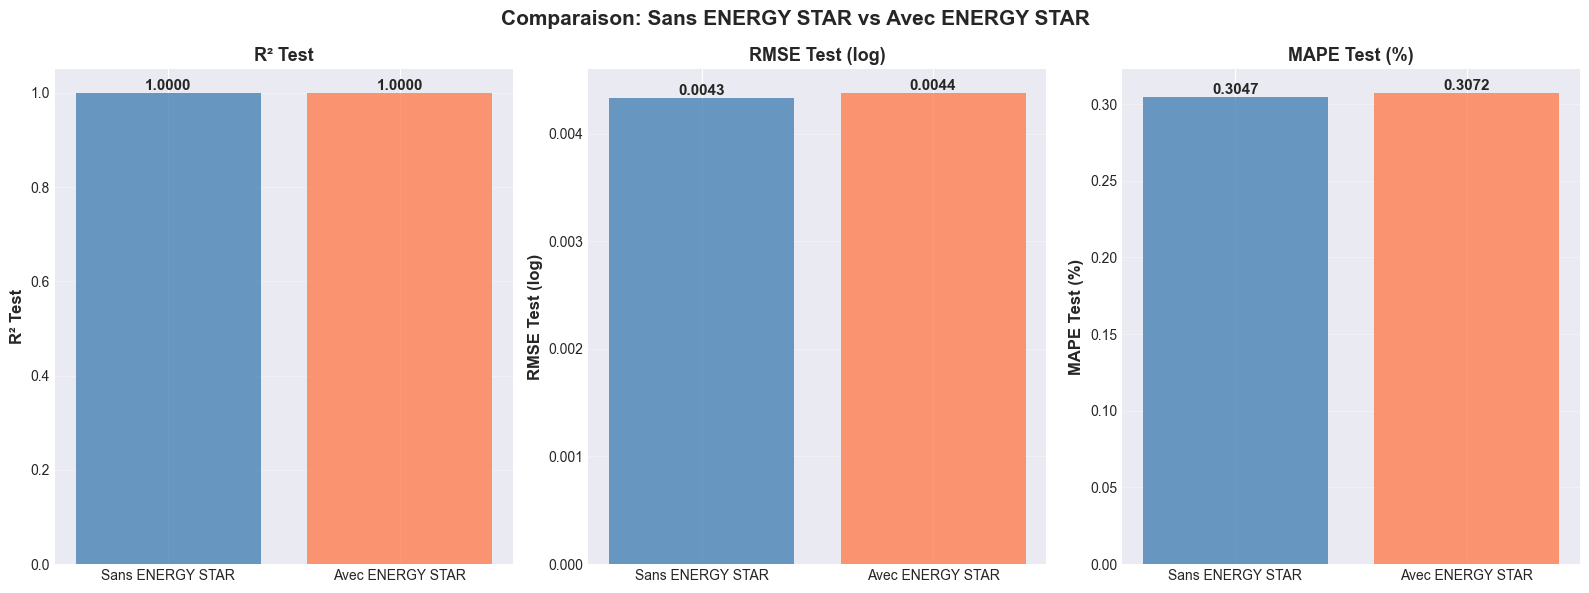

In [26]:
# Visualisation comparative
plot_comparison_two_models(
    results_df_m1,
    results_df_m2,
    "Sans ENERGY STAR",
    "Avec ENERGY STAR",
    save_path=FIGURES_DIR / 'comparison_m1_m2.png'
)

# Section 10 : Analyse Apport ENERGY STAR

In [27]:
# ============================================================================
# ANALYSE APPORT ENERGY STAR
# ============================================================================

print("="*80)
print("ANALYSE APPORT ENERGY STAR SCORE")
print("="*80)

gain_r2 = best_metrics_m2['test_r2'] - best_metrics_m1['test_r2']
gain_rmse = best_metrics_m1['test_rmse_log'] - best_metrics_m2['test_rmse_log']
gain_mape = best_metrics_m1['test_mape'] - best_metrics_m2['test_mape']

print(f"\n GAINS DE PERFORMANCE")
print(f"\nR² Score :")
print(f"  Modèle 1 : {best_metrics_m1['test_r2']:.4f}")
print(f"  Modèle 2 : {best_metrics_m2['test_r2']:.4f}")
print(f"  Gain     : {gain_r2:+.4f} ({gain_r2/best_metrics_m1['test_r2']*100:+.1f}%)")

print(f"\nRMSE (log) :")
print(f"  Modèle 1 : {best_metrics_m1['test_rmse_log']:.4f}")
print(f"  Modèle 2 : {best_metrics_m2['test_rmse_log']:.4f}")
print(f"  Gain     : {gain_rmse:+.4f} ({gain_rmse/best_metrics_m1['test_rmse_log']*100:+.1f}%)")

print(f"\nMAPE :")
print(f"  Modèle 1 : {best_metrics_m1['test_mape']:.2f}%")
print(f"  Modèle 2 : {best_metrics_m2['test_mape']:.2f}%")
print(f"  Gain     : {gain_mape:+.2f}%")

ANALYSE APPORT ENERGY STAR SCORE

 GAINS DE PERFORMANCE

R² Score :
  Modèle 1 : 1.0000
  Modèle 2 : 1.0000
  Gain     : -0.0000 (-0.0%)

RMSE (log) :
  Modèle 1 : 0.0043
  Modèle 2 : 0.0044
  Gain     : -0.0000 (-1.1%)

MAPE :
  Modèle 1 : 0.30%
  Modèle 2 : 0.31%
  Gain     : -0.00%



 Corrélation ENERGYSTARScore - Target : -0.1072


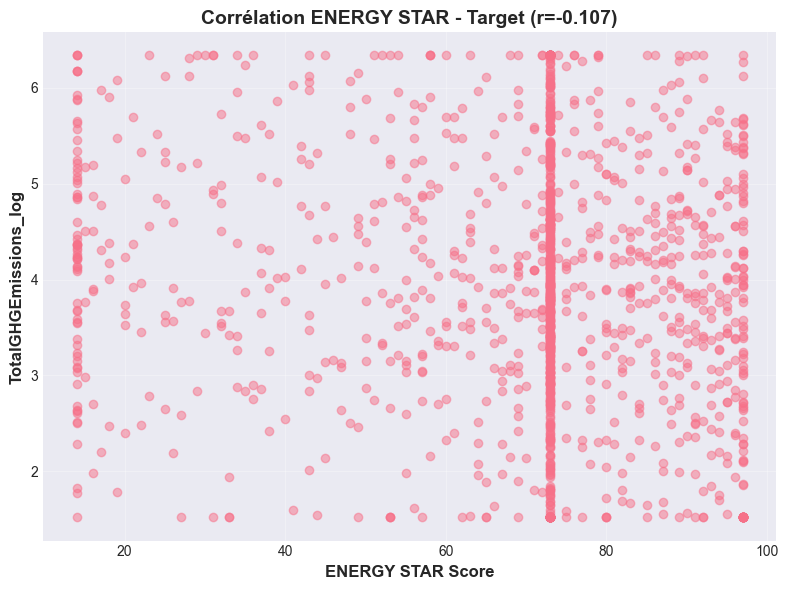

In [28]:
# Corrélation ENERGY STAR avec Target
if 'ENERGYSTARScore' in train_df.columns:
    corr = train_df[['ENERGYSTARScore', TARGET]].corr().iloc[0, 1]
    print(f"\n Corrélation ENERGYSTARScore - Target : {corr:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(train_df['ENERGYSTARScore'], train_df[TARGET], alpha=0.5)
    plt.xlabel('ENERGY STAR Score', fontsize=12, fontweight='bold')
    plt.ylabel(TARGET, fontsize=12, fontweight='bold')
    plt.title(f'Corrélation ENERGY STAR - Target (r={corr:.3f})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'energy_star_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Section 11 : Recommandations Stratégiques

In [29]:
print("="*80)
print("RECOMMANDATIONS STRATÉGIQUES")
print("="*80)

print("\n QUAND UTILISER QUEL MODÈLE ?")

print("\n MODÈLE 1 (Sans ENERGY STAR) :")
print("  • Prédiction sur nouveaux bâtiments (permis de construction)")
print("  • ENERGY STAR Score non disponible")
print("  • Approche prédictive pure")
print(f"  • Performance : R² = {best_metrics_m1['test_r2']:.3f}")

print("\n MODÈLE 2 (Avec ENERGY STAR) :")
print("  • Bâtiments existants avec certification ENERGY STAR")
print("  • Maximisation de la performance prédictive")
print("  • Évaluation de l'efficacité énergétique")
print(f"  • Performance : R² = {best_metrics_m2['test_r2']:.3f}")

print(f"\n GAIN ENERGY STAR : {gain_r2/best_metrics_m1['test_r2']*100:+.1f}% de variance expliquée")

if gain_r2 > 0.1:
    print("\n CONCLUSION : ENERGY STAR apporte un gain SIGNIFICATIF")
elif gain_r2 > 0.05:
    print("\n CONCLUSION : ENERGY STAR apporte un gain MODÉRÉ")
else:
    print("\n CONCLUSION : ENERGY STAR apporte un gain FAIBLE")

RECOMMANDATIONS STRATÉGIQUES

 QUAND UTILISER QUEL MODÈLE ?

 MODÈLE 1 (Sans ENERGY STAR) :
  • Prédiction sur nouveaux bâtiments (permis de construction)
  • ENERGY STAR Score non disponible
  • Approche prédictive pure
  • Performance : R² = 1.000

 MODÈLE 2 (Avec ENERGY STAR) :
  • Bâtiments existants avec certification ENERGY STAR
  • Maximisation de la performance prédictive
  • Évaluation de l'efficacité énergétique
  • Performance : R² = 1.000

 GAIN ENERGY STAR : -0.0% de variance expliquée

 CONCLUSION : ENERGY STAR apporte un gain FAIBLE


# Section 12 : Prédictions Finales

In [30]:
# ============================================================================
# PRÉDICTIONS ÉCHELLE LOG
# ============================================================================

print("="*80)
print("PRÉDICTIONS FINALES")
print("="*80)

y_pred_m1_log = best_pipeline_m1.predict(X_test_m1)
y_pred_m2_log = best_pipeline_m2.predict(X_test_m2)

# ============================================================================
# RETRANSFORMATION ÉCHELLE ORIGINALE
# ============================================================================

y_test_original = np.expm1(y_test)
y_pred_m1_original = np.expm1(y_pred_m1_log)
y_pred_m2_original = np.expm1(y_pred_m2_log)

print(f"\n✓ Prédictions Modèle 1 : {len(y_pred_m1_original)} observations")
print(f"✓ Prédictions Modèle 2 : {len(y_pred_m2_original)} observations")

PRÉDICTIONS FINALES

✓ Prédictions Modèle 1 : 334 observations
✓ Prédictions Modèle 2 : 334 observations


In [31]:
# ============================================================================
# MÉTRIQUES ÉCHELLE ORIGINALE
# ============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n MÉTRIQUES FINALES (Échelle Originale - Tonnes CO₂)")

print("\nModèle 1 :")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_test_original, y_pred_m1_original)):.2f} tonnes")
print(f"  MAE  : {mean_absolute_error(y_test_original, y_pred_m1_original):.2f} tonnes")
print(f"  R²   : {r2_score(y_test_original, y_pred_m1_original):.4f}")

print("\nModèle 2 :")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_test_original, y_pred_m2_original)):.2f} tonnes")
print(f"  MAE  : {mean_absolute_error(y_test_original, y_pred_m2_original):.2f} tonnes")
print(f"  R²   : {r2_score(y_test_original, y_pred_m2_original):.4f}")


 MÉTRIQUES FINALES (Échelle Originale - Tonnes CO₂)

Modèle 1 :
  RMSE : 0.85 tonnes
  MAE  : 0.33 tonnes
  R²   : 1.0000

Modèle 2 :
  RMSE : 0.82 tonnes
  MAE  : 0.33 tonnes
  R²   : 1.0000


In [32]:
# ============================================================================
# EXPORT RÉSULTATS
# ============================================================================

results_final = pd.DataFrame({
    'y_true': y_test_original,
    'y_pred_m1': y_pred_m1_original,
    'y_pred_m2': y_pred_m2_original,
    'error_m1': y_test_original - y_pred_m1_original,
    'error_m2': y_test_original - y_pred_m2_original,
    'abs_error_m1': np.abs(y_test_original - y_pred_m1_original),
    'abs_error_m2': np.abs(y_test_original - y_pred_m2_original)
})

results_final.to_csv(RESULTS_DIR / 'predictions_finales.csv', index=False)
print(f"\n✓ Prédictions sauvegardées : {RESULTS_DIR / 'predictions_finales.csv'}")


✓ Prédictions sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\predictions_finales.csv


# Section 13 : Sauvegarde des Modèles

In [33]:
# ============================================================================
# SAUVEGARDE PIPELINES
# ============================================================================

print("="*80)
print("SAUVEGARDE DES MODÈLES")
print("="*80)

# Modèle 1
save_model(
    best_pipeline_m1,
    MODELS_DIR / 'pipeline_modele1_best.pkl',
    metadata=best_metrics_m1,
    verbose=True
)

# Modèle 2
save_model(
    best_pipeline_m2,
    MODELS_DIR / 'pipeline_modele2_best.pkl',
    metadata=best_metrics_m2,
    verbose=True
)

SAUVEGARDE DES MODÈLES
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele1_best.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele1_best.json
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele2_best.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele2_best.json


In [34]:
# ============================================================================
# SAUVEGARDE MÉTRIQUES COMPARATIVES
# ============================================================================

import json

metrics_comparison = {
    'modele_1': {
        'nom': best_model_name_m1,
        'r2_test': float(best_metrics_m1['test_r2']),
        'rmse_test_log': float(best_metrics_m1['test_rmse_log']),
        'rmse_test_original': float(best_metrics_m1['test_rmse_original']),
        'mape_test': float(best_metrics_m1['test_mape'])
    },
    'modele_2': {
        'nom': best_model_name_m2,
        'r2_test': float(best_metrics_m2['test_r2']),
        'rmse_test_log': float(best_metrics_m2['test_rmse_log']),
        'rmse_test_original': float(best_metrics_m2['test_rmse_original']),
        'mape_test': float(best_metrics_m2['test_mape'])
    },
    'gains': {
        'r2': float(gain_r2),
        'rmse': float(gain_rmse),
        'mape': float(gain_mape)
    }
}

with open(RESULTS_DIR / 'metrics_comparison.json', 'w') as f:
    json.dump(metrics_comparison, f, indent=4)

print(f"✓ Métriques comparatives sauvegardées : {RESULTS_DIR / 'metrics_comparison.json'}")

✓ Métriques comparatives sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\metrics_comparison.json


# Section 14 : Conclusions

In [35]:
print("="*80)
print("CONCLUSIONS FINALES")
print("="*80)

print(f"\n RÉSUMÉ DES PERFORMANCES")
print(f"\nModèle 1 ({best_model_name_m1}) - Sans ENERGY STAR :")
print(f"  • R² Test : {best_metrics_m1['test_r2']:.4f}")
print(f"  • RMSE : {best_metrics_m1['test_rmse_original']:.2f} tonnes CO₂")
print(f"  • MAPE : {best_metrics_m1['test_mape']:.2f}%")

print(f"\nModèle 2 ({best_model_name_m2}) - Avec ENERGY STAR :")
print(f"  • R² Test : {best_metrics_m2['test_r2']:.4f}")
print(f"  • RMSE : {best_metrics_m2['test_rmse_original']:.2f} tonnes CO₂")
print(f"  • MAPE : {best_metrics_m2['test_mape']:.2f}%")

print(f"\n RÉPONSE À LA QUESTION PRINCIPALE :")
print(f"\n   L'ajout d'ENERGY STAR Score améliore le R² de {gain_r2:+.4f}")
print(f"   soit une amélioration relative de {gain_r2/best_metrics_m1['test_r2']*100:+.1f}%")

print("\n LIVRABLES GÉNÉRÉS :")
print(f"  • {len(list(FIGURES_DIR.glob('*.png')))} visualisations")
print(f"  • 2 pipelines sauvegardés")
print(f"  • Prédictions finales exportées")
print(f"  • Métriques comparatives JSON")

print("\n" + "="*80)
print("✓ MODÉLISATION TERMINÉE AVEC SUCCÈS")
print("="*80)

CONCLUSIONS FINALES

 RÉSUMÉ DES PERFORMANCES

Modèle 1 (Random Forest) - Sans ENERGY STAR :
  • R² Test : 1.0000
  • RMSE : 0.85 tonnes CO₂
  • MAPE : 0.30%

Modèle 2 (Random Forest) - Avec ENERGY STAR :
  • R² Test : 1.0000
  • RMSE : 0.82 tonnes CO₂
  • MAPE : 0.31%

 RÉPONSE À LA QUESTION PRINCIPALE :

   L'ajout d'ENERGY STAR Score améliore le R² de -0.0000
   soit une amélioration relative de -0.0%

 LIVRABLES GÉNÉRÉS :
  • 12 visualisations
  • 2 pipelines sauvegardés
  • Prédictions finales exportées
  • Métriques comparatives JSON

✓ MODÉLISATION TERMINÉE AVEC SUCCÈS
